# Figure 4: Nonlinear Control
In this Notebook, we shall create a plot showing control performed through a Spike Coding Network (SCN). The plot shows two Cartpole systems, of which one is controlled through an SCN estimator and controller, and the other through an idealized LQG controller. The work in this notebook is carried out for "Closed-form control with spike coding networks" by F.S. Slijkhuis, S.W. Keemink and P. Lanillos (https://doi.org/10.48550/arXiv.2212.12887).

## Imports
Nothing too special here, we shall use Numpy for matrices and Matplotlib for plotting. The Python-files initialization.py and simulation.py contain helper functions which will prevent clutter in this notebook. Please refer to the files themselves to learn more about the functions within them.

In [1]:
import numpy as np #Numpy for matrix calculations
import matplotlib.pyplot as plt #Matplotlib for plotting
import initialization, simulation #Helper functions for initialization and simulation are located in these two Python files. Please see the files themselves for more details.

## Initialization
For initialization, we shall define parameters relevant to the simulations in this notebook. As mentioned earlier, we are simulating two Cartpole systems: one controlled using an SCN controller and the other through an idealized LQG. Both the controllers and Cartpole systems will be simulated using Forward Euler. But first, we must define the relevant parameters.

In [2]:
#Forward Euler parameters
time = 50 #Total simulation time in seconds
dt = 0.0001 #Length of a single timestep

#Parameters for cartpole on a cart
m = 1 #mass of pendulum
M = 5 #mass of cart
L = 2 #length of pendulum
g = -10 #gravity
d = 1 #damping on cart (friction)
s = 1 #s=1 for pendulum up. s=-1 for pendulum down
x0 = np.array([5, 0, np.pi, 0]) #initial position, initial velocity, initial angle, initial angular velocity

#Other system parameters
C=np.array([[1,0,0,0],
            [0,0,0,0],
            [0,0,0,0],
            [0,0,0,0]]) #Initialization of the C matrix (because y=Cx+noise)
Vn_cov = .0000001 #Sensor noise covariance (y=Cx+noise)
Vd_cov = .0000001 #Disturbance noise covariance (noise on the SMD)

#SCN Controller parameters
network_size = 100 #The number of neurons in the SCN
signal_dimensions = 8 #The dimensions of the signal, which is 8 here because the target state is also encoded into the network
lam = 0.1 #The leakage constant of the network, lambda
Vv_sigma = 0.000001 #Voltage noise sigma; noise on the voltage

#Control parameters
Q = np.array([[1,0,0,0],
              [0,1,0,0],
              [0,0,10,0],
              [0,0,0,1]]) #The Q-matrix, cost of deviations from the state
R = 0.001 #Cost of actuation

Next, we shall run some of the code from initialization.py, required to initialize some of the parameters and matrices used in the simulation loop.

In [3]:
#Forward Euler simulation
times,Nt = initialization.FE_init(time,dt) #times is a list of timesteps which we will loop over, Nt is the total number of timesteps (length of times)

#SMD System A and B matrices
A,B = initialization.Cartpole_init(m,M,L,g,d,s) #A and B are the system matrix and input matrix in state-space representation (according to Ax+Bu)

#Initialization of the Kalman filter gain matrix to be used inside of the SCN estimator and idealized Kalman filter
Kf = initialization.Kalman_init(A,C,Vn_cov,Vd_cov) #From the A and C matrices and noise covariances, we can calculate the Kalman filter gain matrix

#Initialization of the LQR gain matrix to be used inside of the SCN controller and idealized LQG
Kc = initialization.Control_init(A,B,Q,R)

#Initialization of the state-matrices, containing the states of the simulated Cartpole systems over time
X = initialization.X_init(x0,Nt) #Requires x0 as the first state of the simulated Cartpole system, and Nt for the matrix dimensions
X_2 = initialization.X_init(x0,Nt) #We run two Cartpole systems with different controllers, so we need two state matrices

#Target state parameters
x0_des = np.full([Nt+1],0) # Desired x0, position cart
x1_des = np.full([Nt+1],0) # Desired x1, velocity cart
x2_des = np.full([Nt+1],np.pi) # Desired x2, pos of pendulum
x3_des = np.full([Nt+1],0) # Desired x3, ang. velocity

#Change desired state over time
x0_des[int(Nt/5):int(Nt/5)*2] = 1
x0_des[int(Nt/5)*2:int(Nt/5)*3] = 2
x0_des[int(Nt/5)*3:int(Nt/5)*4] = 3
x0_des[int(Nt/5)*4:] = 4

x_des = np.array([x0_des,x1_des,x2_des,x3_des]) # Desired states over time.


#We require that between the linearized estimators and the simulated cartpole, the angle is converted by subtracting pi from the original value
x0_converted=np.concatenate((x0, x_des[:,0])) #Concatenate x0 and x_des because we encode both the estimated state and the target state into the SCN
x0_converted[2]=x0_converted[2]-np.pi #For the estimated state
x0_converted[6]=x0_converted[6]-np.pi #For the target state

#Initializaton of the SCN controller, given parameters, we calculate D, T, V, s, r and all of the connectivity
D,T,V,s,r,O_f,O_s,O_c,F_c,O_k,F_k = initialization.ControllerSCN_init(signal_dimensions,Nt,A,B,C,Kf,Kc,network_size,lam,bounding_box_factor=100,zero_init=False,x0=x0_converted) #Smaller bounding box, init SCN at Cartpole init

#Error matrices, will be updated during the simulation
error_ideal=np.zeros([len(x0),Nt+1]) #Error between idealzied LQG and SMD system
error_scn=np.zeros([len(x0),Nt+1]) #Error between SCN controller and SMD system

#Initialization of other matrices used in simulation, U, Y, X_hat (state matrix of SCN estimator), X_hat_fe (state matrix of idealized Kalman filter), uDIST and uNOISE (noise matrices)
U,Y,U_2,Y_2,X_hat,X_hat_fe,uDIST,uNOISE,Dx,error_scn,error_ideal = initialization.ControlLoop_init(X,X_2,error_scn,error_ideal,x_des,dt,A,B,C,x0,Nt,Vd_cov,Vn_cov)

#X-matrices must be converted because of linearization, e.g. pi must be subtracted
X_hat_fe[:,0]=x0_converted[:4]
X_converted=np.zeros([len(x0[:4]),Nt+1])
X_converted[:,0]=x0_converted[:4]
X_hat_converted=np.zeros([len(x0[:4]),Nt+1])
X_hat_converted[2,0]=X_hat_converted[2,0]+np.pi
x_des_converted=x_des
x_des_converted[2]=x_des_converted[2]-np.pi
X_2_converted=np.zeros([len(x0[:4]),Nt+1])
X_2_converted[:,0]=x0_converted[:4]

#We require the same operations for Y, we must use the converted matrices to initialize
Y[:,0] = C@X_converted[:,0] + uNOISE[:,0]
U[0,0] = -Kc @ (D[:-4] @ r[:,0] - D[4:] @ r[:,0])
Y_2[:,0] = C@X_2_converted[:,0] + uNOISE[:,0]
U_2[0,0] = -Kc @ (X_2_converted[:,0]-x_des[:,0])

Rank of controllability-matrix: 4


## Simulation
Now that we have defined all of the parameters we need, we can define how to run the simulation. For individual Cartpole and SCN steps, we shall make use of simulation.py.

In [4]:
def run_simulation(Nt,X,X_2,A,B,U,U_2,uDIST,dt,Y,Y_2,C,uNOISE,r,s,V,D,T,lam,O_f,O_s,O_c,F_c,O_k,F_k,Vv_sigma,X_hat,X_hat_fe,Kf,Kc,x_des,error_scn,error_ideal,signal_dimensions):
    #Looping over the entire range of Nt, we have all the timesteps in our simulation
    for t in range(Nt):
        #First, simulate one step of both simulated SMD system
        X[:,t+1] = simulation.run_Cartpolereal_step(X[:,t],U[0,t],uDIST[:,t],m,M,L,g,d,dt)
        X_2[:,t+1] = simulation.run_Cartpolereal_step(X_2[:,t],U_2[0,t],uDIST[:,t],m,M,L,g,d,dt)
        
        #Update the error matrices
        error_scn[:,t+1] = np.abs(X[:,t+1]-x_des[:,t+1]-np.pi)
        error_ideal[:,t+1] = np.abs(X_2[:,t+1]-x_des[:,t+1]-np.pi)
        
        #Again, we convert from the real system to the linearized one by subtracting pi from the angle
        X_converted[:,t+1]=X[:,t+1]
        X_converted[2,t+1]=X_converted[2,t+1]-np.pi
        X_2_converted[:,t+1]=X_2[:,t+1]
        X_2_converted[2,t+1]=X_2_converted[2,t+1]-np.pi

        #Our controllers only have access to Y, which is the partially observable state plus noise
        Y[:,t+1] = C@X_converted[:,t+1] + uNOISE[:,t+1]
        Y_2[:,t+1] = C@X_2_converted[:,t+1] + uNOISE[:,t+1]

        #Simulate a single step of the SCN controller
        r[:,t+1],s[:,t+1],V[:,t+1],U[:,t+1] = simulation.run_SCNcontrol_step(Y[:,t],x_des_converted[:,t],Dx[:,t],r[:,t],s[:,t],V[:,t],D,T,lam,Kc,O_f,O_s,O_c,F_c,O_k,F_k,B,C,t,dt,Vv_sigma)
        
        #Run a step of the idealized controller which we compare the SCN to
        X_hat_fe[:,t+1] = simulation.run_Kfidealized_step(X_hat_fe[:,t],A,B,U_2[:,t],Kf,Y_2[:,t],C,dt)
        
        #For the controller, we convert back
        X_hat_converted[:,t+1]=X_hat_fe[:4,t+1]
        X_hat_converted[2,t+1]=X_hat_converted[2,t+1]+np.pi

        #U_2 is the control signal of the idealized controller
        U_2[:,t+1] = -Kc@(X_hat_fe[:,t+1]-x_des[:,t])
    
    return X,X_2,error_scn,error_ideal,s

Next, we run a single simulation for plotting.

In [5]:
X_SCN,X_ideal,error_scn,error_ideal,s = run_simulation(Nt,X,X_2,A,B,U,U_2,uDIST,dt,Y,Y_2,C,uNOISE,r,s,V,D,T,lam,O_f,O_s,O_c,F_c,O_k,F_k,Vv_sigma,X_hat,X_hat_fe,Kf,Kc,x_des,error_scn,error_ideal,signal_dimensions)

## Plotting
Now that we have obtained our filled state matrices, we can plot everything.

<Figure size 432x288 with 0 Axes>

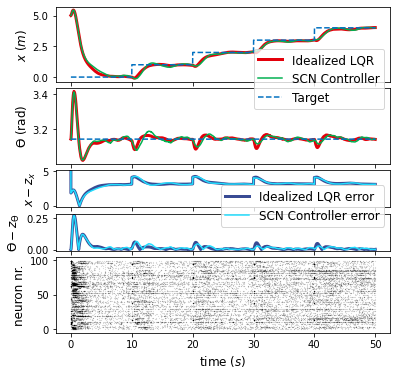

In [6]:
fig = plt.figure()
fig, axs = plt.subplots(5,1, sharex=True, squeeze=True, gridspec_kw = {'hspace':0.1,'height_ratios':[1,1,0.5,0.5,1]})
fig.set_figheight(6)
legend_fontsize=12

legend=[]
axs[0].plot(np.arange(0,time+dt,dt),X_ideal[0],color='#E3000B',linewidth=3)
legend.append("x$^*_{"+str(1)+"}$")
axs[0].plot(np.arange(0,time+dt,dt),X_SCN[0],color='#00B050')
legend.append("x$_{"+str(1)+"}$")
axs[0].plot(np.arange(0,time+dt,dt),x_des[0],linestyle='dashed',c="#0070C0")
legend.append("z$_{1}$")

legend=[]
axs[1].plot(np.arange(0,time+dt,dt),X_ideal[2],color='#E3000B',linewidth=3)
legend.append("Idealized LQR")
axs[1].plot(np.arange(0,time+dt,dt),X_SCN[2],color='#00B050')
legend.append("SCN Controller")
axs[1].plot(np.arange(0,time+dt,dt),x_des[2]+np.pi,linestyle='dashed',c="#0070C0")
legend.append("Target")
axs[1].legend(legend,fontsize=legend_fontsize,loc='upper right',bbox_to_anchor=(1,1.6))

axs[0].set_ylabel('$x$ $(m)$',fontsize = 12)
axs[1].set_ylabel('$ϴ$ (rad)',fontsize = 12)

legend=[]
axs[2].plot(np.arange(0,time+dt,dt),error_ideal[0],color='#394b94',linewidth=3)
legend.append("x$_{"+str(1)+"}$ - x$^*_{"+str(1)+"}$")
axs[2].plot(np.arange(0,time+dt,dt),error_scn[0],color='#22deff')
legend.append("x$_{"+str(2)+"}$ - x$^*_{"+str(2)+"}$")
axs[2].set_ylabel('$x-z_{x}$',fontsize = 12)

legend=[]
axs[3].plot(np.arange(0,time+dt,dt),error_ideal[2],color='#394b94',linewidth=3)
legend.append("Idealized LQR error")
axs[3].plot(np.arange(0,time+dt,dt),error_scn[2],color='#22deff')
legend.append("SCN Controller error")
axs[3].legend(legend,fontsize=legend_fontsize,loc='center right',bbox_to_anchor=(1,1.2))
axs[3].set_ylabel('$ϴ-z_{ϴ}$',fontsize = 12)

#We use a scatterplot for the spike trains:
axs[4].scatter(np.nonzero(s)[1]/10000,np.nonzero(s)[0],marker=".",s=0.01,color='black')
axs[4].set_xlabel('time ($s$)',fontsize = 12)
axs[4].set_ylabel('neuron nr.',fontsize = 12)

plt.savefig('./img/fig5b.png', facecolor='white', transparent=False, dpi=300, bbox_inches='tight')
plt.show()